In [10]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab
pylab.rcParams['figure.figsize'] = (10, 6)

dir = '/Users/mrefermat/git/FinancePhD/Empirical Methods/'

file1 = 'Copy of PredictorData2014.xlsx'
file2 = 'measurestailrisk.xlsx'
file3 = 'VRPtable.txt'

In [11]:
tail_data = pd.read_excel(dir+file2,parse_dates=[[0,1]],index_col=0).resample(rule='m',how='last')
vol = pd.read_csv(dir+file3,delim_whitespace=True,parse_dates=[[0,1]],index_col=0).resample(rule='m',how='last')
pred = pd.read_excel(dir+file1,sheetname='Monthly',parse_dates=[[0,1]],index_col=0).resample(rule='m',how='last')
pred['dy']=pred.D12 / pred.Index
pred['spread']=(pred.BAA-pred.AAA)

For this first one I need to find the base case assuming an AR(6) since we are using monthly data.  From this case we can understand how much adding a predictor improves model.  Do to all of the shifting I use data starting from 1991.  Here is the base case regression:

$$ \sigma_t = \alpha + \sum_1^6 \rho_{t,i} \sigma_{t-i} + \varepsilon_t $$

For each of the volatility measures I will generate the following least squares regressions in order to find out how much predicitive power they are adding to the equation.  The regression just adds one factor (or all as in the case of the 'kitchen sink' approach).  
$$ \sigma_t = \alpha + \sum_1^6 \rho_{t,i} \sigma_{t-i}  + \hat{\beta_t} X + \varepsilon_t $$

In [16]:
types_vol=['IV','RV','EVRP']
r2_values=[]
for v in types_vol:
    X=tail_data.shift()
    X['T-1']=vol.IV.shift()
    X['T-2']=vol.IV.shift(2)
    X['T-3']=vol.IV.shift(3)
    X['T-4']=vol.IV.shift(4)
    X['T-5']=vol.IV.shift(5)
    X['T-6']=vol.IV.shift(6)
    ar6=['T-1','T-2','T-3','T-4','T-5','T-6']
    r= sm.OLS((vol[v])['1991':'2013'],X['1991':'2013'][ar6]).fit()
    r2_values.append(r.rsquared)    
base_r2 = pd.Series(r2_values,index=types_vol)

In [21]:
types_pred=list(tail_data.columns)
r2={}
beta={}
for v in types_vol:
    r2_values=[]
    b_values=[]
    X=tail_data.shift()
    X['T-1']=vol.IV.shift()
    X['T-2']=vol.IV.shift(2)
    X['T-3']=vol.IV.shift(3)
    X['T-4']=vol.IV.shift(4)
    X['T-5']=vol.IV.shift(5)
    X['T-6']=vol.IV.shift(6)
    for p in types_pred:
        r= sm.OLS((vol[v])['1991':'2013'],X['1991':'2013'][ar6 +[p]]).fit()
        r2_values.append(r.rsquared)
        b_values.append(r.params[p])
    r= sm.OLS((vol[v])['1991':'2013'],X['1991':'2013'][ar6 + types_pred]).fit()
    r2_values.append(r.rsquared)                                       
    r2[v] = pd.Series(r2_values,index=types_pred + ['Kitchen Sink'])
    beta[v] = pd.Series(b_values,index=types_pred)                                       
beta = pd.DataFrame(beta) 
r2 = pd.DataFrame(r2)
improved_r2= r2-base_r2

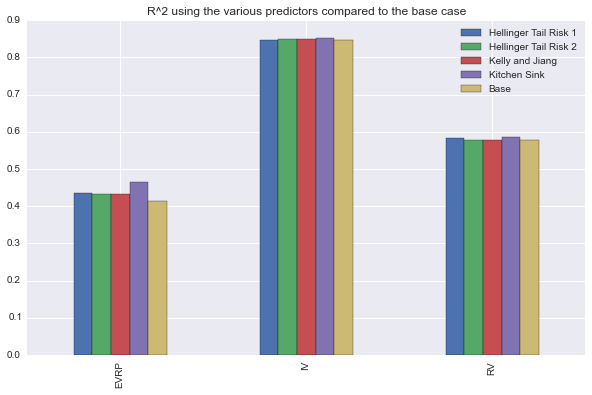

In [22]:
x=r2.T
x['Base']=base_r2
x.plot(kind='bar', title='R^2 using the various predictors compared to the base case')

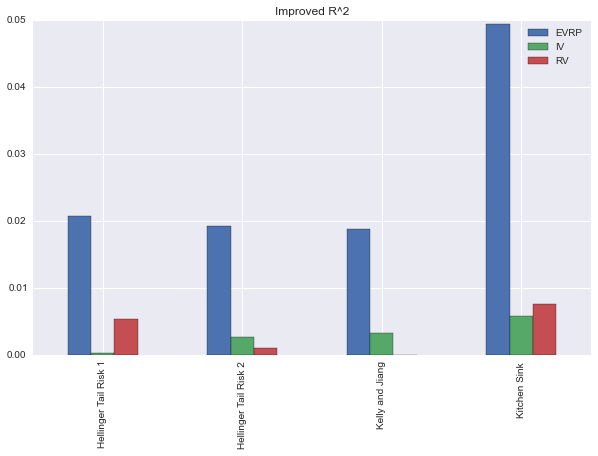

In [23]:
improved_r2.plot(kind='bar',title='Improved R^2')

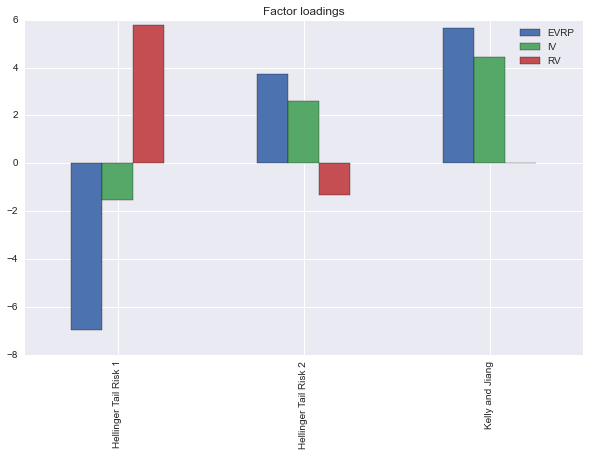

In [24]:
beta.plot(kind='bar',title='Factor loadings')